In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os

sns.set_style("white")
sns.set_palette("husl")


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [3]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.experiment_name = experiment_name
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                          self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            if self.top_k == 1:
                label = "Baseline, LR: {}".format(self.lr)
            else:
                label = "Selective-Backprop, LR: {}".format(self.lr)
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 

        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    

In [20]:
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=500)
    
    if show:
        plt.show()
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.7)
    plt.ylabel(ylabel, fontsize=label_size * 1.7)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size*1.6})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        
def find_first_x_at_y(xs, ys, ymarker):
    if ymarker is None:
        return None
    for x, y in zip(xs, ys):
        if y >= ymarker:
            return x
    return None

In [38]:

def plot(xs_by_config,
         ys_by_config,
         xlabel,
         ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         xlim=None,
         xmin=None,
         ymarker=None):
    xmax = - float("inf")
    ymax = - float("inf")
        
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]

        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9,zorder=0)
             
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = find_first_x_at_y(xs, ys, ymarker)
        print("xmarker: ", xmarker)
        if xmarker:
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
        
        if max(xs) > xmax:
            xmax = max(xs)
        if max(ys) > ymax:
            ymax = max(ys)
        if xlim:
            if xmin:
                plt.xlim(xmin, xlim)
            plt.xlim(xmin, xlim)
    
    if len(ys_by_config.keys()) > 0:
        if ymin is not None:
            plt.ylim(ymin, ymax)
        plt.ylim(ymin, ymax)
        if ylabel == "Aggregate Ratio Backpropped":
            plt.ylim(0, 1.5)
        plot_prefix = "{}/{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                            ylabel,
                                            config.lr)
        format_plot(xlabel, ylabel)
        write_file(plot_prefix, show=True)



In [42]:
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xlim=None,
                     xmin=None,
                     ymin=None,
                     ymarker=None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop / 1000000. \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]

            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Aggregate Ratio Backpropped", plot_dir, smoothing, lw=3, ymin=0, xlim=xlim)
    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xlim=xlim)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, xlim=xlim, xmin=xmin, ymarker=ymarker)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xlim=xlim)

In [43]:
def plot_image_distributions(experiment_name, pickles_dir, plot_dir, epoch=None, trials=None):
    print("In plot_image_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename, experiment_name)
        if trials:
            if config.trial not in trials:
                continue
        if epoch and "epoch_{}".format(epoch) not in filename:
            continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        alpha=0.75)

            plt.xlim(0, max(d.values()) + 1)
            format_plot("Number of Backprops", "Number of Images")

            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix) 


deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial3_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial3_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial3_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial3_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 15834 15834
('xmarker: ', None)
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 6399 6399
('xmarker: ', None)
Num Images Backp

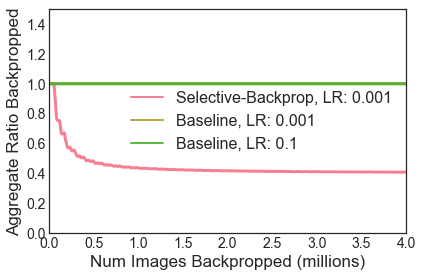

Num Images Backpropped (millions) , Training Loss 62500 62500
('xmarker: ', None)
Num Images Backpropped (millions) , Training Loss 62500 62500
('xmarker: ', None)
Num Images Backpropped (millions) , Training Loss 62500 62500
('xmarker: ', None)


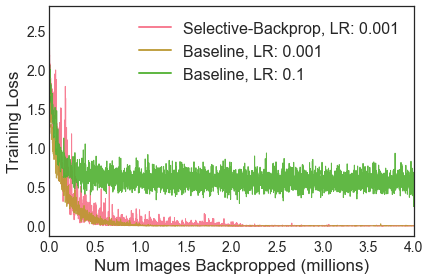

Num Images Backpropped (millions) , Test Accuracy 15835 15835
('xmarker: ', 3.005312)
Num Images Backpropped (millions) , Test Accuracy 6400 6400
('xmarker: ', 8.9128)
Num Images Backpropped (millions) , Test Accuracy 6400 6400
('xmarker: ', None)


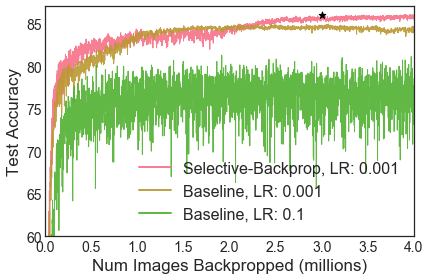

Num Images Forward Propped (millions) , Test Accuracy 15835 15835
('xmarker: ', 7.297908)
Num Images Forward Propped (millions) , Test Accuracy 6400 6400
('xmarker: ', 8.9128)
Num Images Forward Propped (millions) , Test Accuracy 6400 6400
('xmarker: ', None)


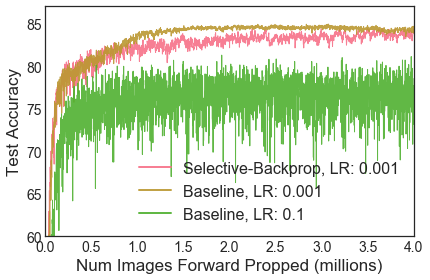

Num Images Backpropped (millions) , Test Loss 15835 15835
('xmarker: ', None)
Num Images Backpropped (millions) , Test Loss 6400 6400
('xmarker: ', None)
Num Images Backpropped (millions) , Test Loss 6400 6400
('xmarker: ', None)


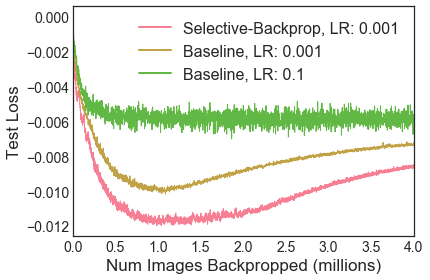

deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial3_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.01_0.0005_trial3_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial3_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial3_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 15834 15834
('xmarker: ', None)
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 6399 6399
('xmarker: ', None)


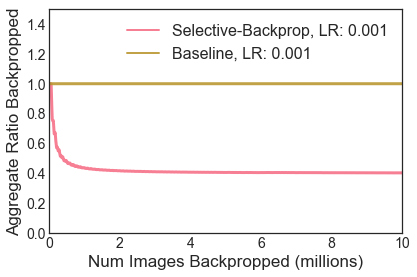

Num Images Backpropped (millions) , Training Loss 62500 62500
('xmarker: ', None)
Num Images Backpropped (millions) , Training Loss 62500 62500
('xmarker: ', None)


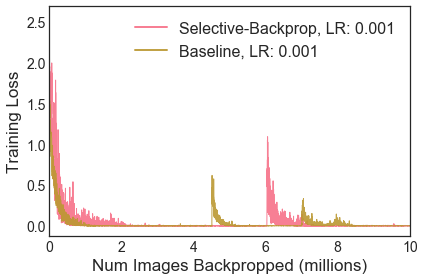

Num Images Backpropped (millions) , Test Accuracy 15835 15835
('xmarker: ', 3.005312)
Num Images Backpropped (millions) , Test Accuracy 6400 6400
('xmarker: ', 8.9128)


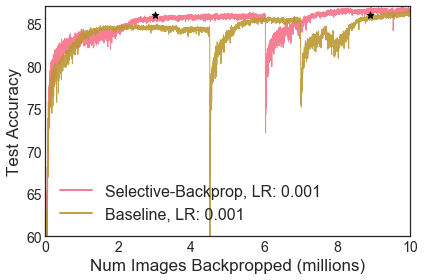

Num Images Forward Propped (millions) , Test Accuracy 15835 15835
('xmarker: ', 7.297908)
Num Images Forward Propped (millions) , Test Accuracy 6400 6400
('xmarker: ', 8.9128)


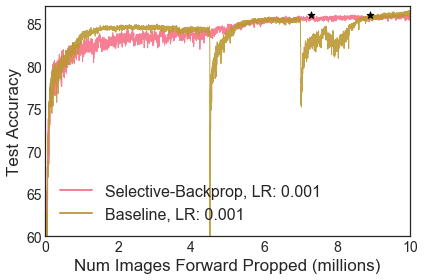

Num Images Backpropped (millions) , Test Loss 15835 15835
('xmarker: ', None)
Num Images Backpropped (millions) , Test Loss 6400 6400
('xmarker: ', None)


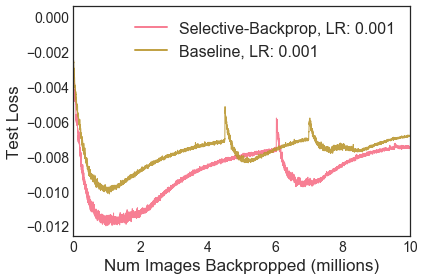

<Figure size 432x288 with 0 Axes>

In [28]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/181016_notransform/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181016_notransform_square",
                    "181016_notransform_baseline_square",
                    "181016_notransform_baseline_translate"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 lrs=[0.001, 0.1],
                 sampling_mins=[0.4, 1],
                 trials=[1],
                 xlim=4,
                 ymarker=86)

plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 lrs=[0.001],
                 sampling_mins=[0.4, 1],
                 trials=[1],
                 xlim=10,
                 ymarker=86)



sampling_mnist_lecunn_.1_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.1_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.1_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial3_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 4243 4243
('xmarker: ', None)
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 632 632
('xmarker: ', None)


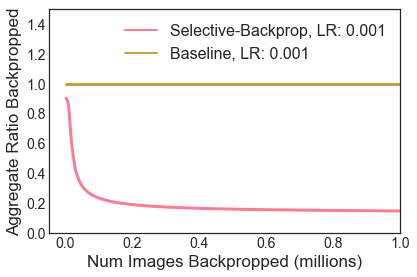

Num Images Backpropped (millions) , Training Loss 6250 6250
('xmarker: ', None)
Num Images Backpropped (millions) , Training Loss 6250 6250
('xmarker: ', None)


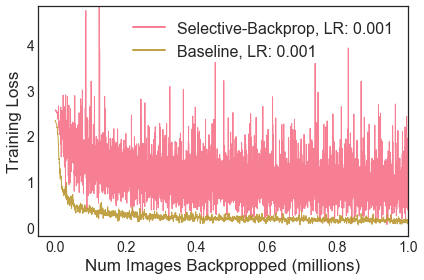

Num Images Backpropped (millions) , Test Accuracy 4244 4244
('xmarker: ', 0.175616)
Num Images Backpropped (millions) , Test Accuracy 633 633
('xmarker: ', 0.6952)


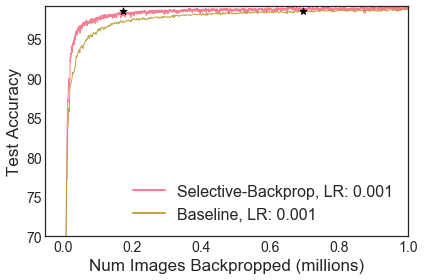

Num Images Backpropped (millions) , Test Loss 4244 4244
('xmarker: ', None)
Num Images Backpropped (millions) , Test Loss 633 633
('xmarker: ', None)


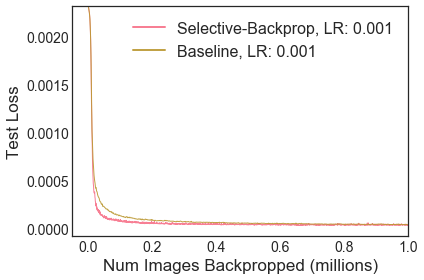

<Figure size 432x288 with 0 Axes>

In [44]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/mnist/"

plot_dir = "{}/181019_mnist/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181019_mnist_square"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 trials=[1],
                 sampling_mins=[0.1, 1],
                 xlim=1,
                 ymin=70,
                 ymarker=98.5)


deterministic_cifar10_resnet_.4_32_0.1_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.1_0.0005_trial1_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 1611 1611
('xmarker: ', None)
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 1303 1303
('xmarker: ', None)


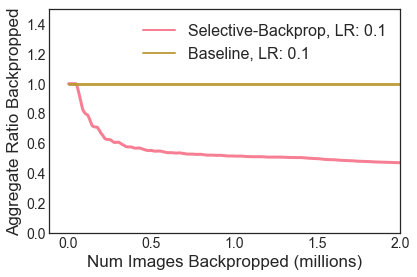

Num Images Backpropped (millions) , Training Loss 14536 14536
('xmarker: ', None)
Num Images Backpropped (millions) , Training Loss 25477 25477
('xmarker: ', None)


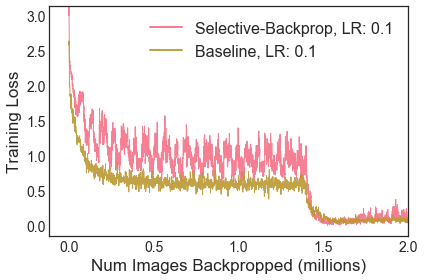

Num Images Backpropped (millions) , Test Accuracy 1612 1612
('xmarker: ', 0.360544)
Num Images Backpropped (millions) , Test Accuracy 1304 1304
('xmarker: ', 1.4048)


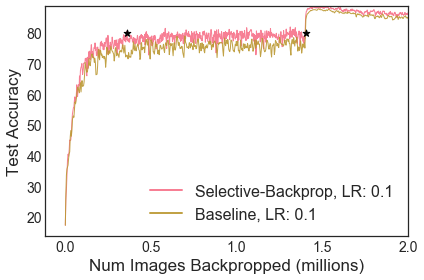

Num Images Backpropped (millions) , Test Loss 1612 1612
('xmarker: ', None)
Num Images Backpropped (millions) , Test Loss 1304 1304
('xmarker: ', None)


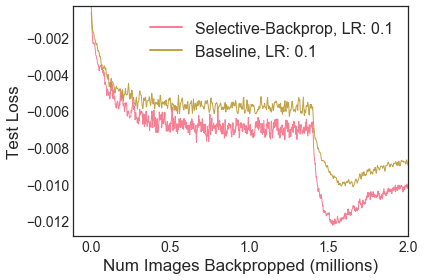

<Figure size 432x288 with 0 Axes>

In [49]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/181026_lr_square/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["181026_lr_square"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 smoothing=1,
                 xlim=2,
                 ymarker=80)